In [1]:
import os
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
import joblib

In [7]:
import xgboost as xgb
# reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

#Environment Verification
print("Environment ready. numpy/pandas/sklearn version:", np.__version__, pd.__version__)

Environment ready. numpy/pandas/sklearn version: 2.1.3 2.2.3


In [8]:
df = pd.read_csv("sensor_maintenance_data.csv")
print("-------------------------------------------------------------------------------------------")
print("DATA LOADED SUCCESSFULLY")

-------------------------------------------------------------------------------------------
DATA LOADED SUCCESSFULLY


In [9]:
# common timestamp columns to unify
possible_time_cols = ["timestamp", "time", "datetime", "event_timestamp", "ts"]
for c in possible_time_cols:
    if c in df.columns:
        # standardize name
        df.rename(columns={c: "timestamp"}, inplace=True)
        break

# print overview
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())
display(df.info())
display(df.isna().sum().sort_values(ascending=False).head(20))


Shape: (500, 27)
Columns: ['Sensor_ID', 'Timestamp', 'Voltage (V)', 'Current (A)', 'Temperature (°C)', 'Power (W)', 'Humidity (%)', 'Vibration (m/s²)', 'Equipment_ID', 'Operational Status', 'Fault Status', 'Failure Type', 'Last Maintenance Date', 'Maintenance Type', 'Failure History', 'Repair Time (hrs)', 'Maintenance Costs (USD)', 'Ambient Temperature (°C)', 'Ambient Humidity (%)', 'External Factors', 'X', 'Y', 'Z', 'Equipment Relationship', 'Equipment Criticality', 'Fault Detected', 'Predictive Maintenance Trigger']


,Sensor_ID,Timestamp,Voltage (V),Current (A),Temperature (°C),Power (W),Humidity (%),Vibration (m/s²),Equipment_ID,Operational Status,...,Ambient Temperature (°C),Ambient Humidity (%),External Factors,X,Y,Z,Equipment Relationship,Equipment Criticality,Fault Detected,Predictive Maintenance Trigger
0,S_1,2024-01-01 00:00:00,110,0.5,20,55.0,40,0.20,E_1,Operational,...,20,40,Clear Weather,0,0,0,Independent,High,1,1
1,S_2,2024-01-01 01:00:00,111,0.6,21,66.6,41,0.25,E_2,Under Maintenance,...,21,41,Storm,1,1,1,Dependent,Medium,0,0
2,S_3,2024-01-01 02:00:00,112,0.7,22,78.4,42,0.30,E_3,Operational,...,22,42,Clear Weather,2,2,2,Dependent,High,0,0
3,S_4,2024-01-01 03:00:00,113,0.8,23,90.4,43,0.35,E_4,Under Maintenance,...,23,43,Storm,3,3,3,Independent,Medium,1,0
4,S_5,2024-01-01 04:00:00,114,0.9,24,102.6,44,0.40,E_5,Operational,...,24,44,Clear Weather,4,4,4,Dependent,High,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Sensor_ID                       500 non-null    object 
 1   Timestamp                       500 non-null    object 
 2   Voltage (V)                     500 non-null    int64  
 3   Current (A)                     500 non-null    float64
 4   Temperature (°C)                500 non-null    int64  
 5   Power (W)                       500 non-null    float64
 6   Humidity (%)                    500 non-null    int64  
 7   Vibration (m/s²)                500 non-null    float64
 8   Equipment_ID                    500 non-null    object 
 9   Operational Status              500 non-null    object 
 10  Fault Status                    500 non-null    object 
 11  Failure Type                    200 non-null    object 
 12  Last Maintenance Date           500 

None

Failure Type                300
Timestamp                     0
Sensor_ID                     0
Current (A)                   0
Temperature (°C)              0
Power (W)                     0
Humidity (%)                  0
Vibration (m/s²)              0
Equipment_ID                  0
Operational Status            0
Voltage (V)                   0
Fault Status                  0
Last Maintenance Date         0
Maintenance Type              0
Failure History               0
Repair Time (hrs)             0
Maintenance Costs (USD)       0
Ambient Temperature (°C)      0
Ambient Humidity (%)          0
External Factors              0
dtype: int64

In [10]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

data = df.copy()

## ---- 2.1 Target Variable ----
target = 'Fault Detected'
y = data[target]   # Binary classification target

## ---- 2.2 Handle datetime columns ----
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Last Maintenance Date'] = pd.to_datetime(data['Last Maintenance Date'])

# Extract useful time features
data['hour'] = data['Timestamp'].dt.hour
data['day'] = data['Timestamp'].dt.day
data['month'] = data['Timestamp'].dt.month
data['dayofweek'] = data['Timestamp'].dt.dayofweek

## ---- 2.3 Handle missing values ----
# Failure Type has ~300 nulls -> replace with 'None'
data['Failure Type'] = data['Failure Type'].fillna('None')

# Other numerical columns: fill missing with median
for col in data.select_dtypes(include=['float64','int64']).columns:
    if data[col].isnull().sum() > 0:
            data[col] = data[col].fillna(data[col].median())


## ---- 2.5 Handle outliers ----
num_cols = data.select_dtypes(include=['float64','int64']).columns
for col in num_cols:
    Q1, Q3 = data[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    data[col] = np.where(data[col] < lower, lower, data[col])
    data[col] = np.where(data[col] > upper, upper, data[col])

## ---- 2.6 Scale features ----
scaler = StandardScaler()
scaled_cols = data.select_dtypes(include=['float64','int64']).columns
data[scaled_cols] = scaler.fit_transform(data[scaled_cols])

print("\nPreprocessing Complete")
print("Processed Data Preview:")
print(data.head())


Preprocessing Complete
Processed Data Preview:
  Sensor_ID           Timestamp  Voltage (V)  Current (A)  Temperature (°C)  \
0       S_1 2024-01-01 00:00:00    -1.566699    -1.414214         -1.566699   
1       S_2 2024-01-01 01:00:00    -1.218544    -0.707107         -1.218544   
2       S_3 2024-01-01 02:00:00    -0.870388     0.000000         -0.870388   
3       S_4 2024-01-01 03:00:00    -0.522233     0.707107         -0.522233   
4       S_5 2024-01-01 04:00:00    -0.174078     1.414214         -0.174078   

   Power (W)  Humidity (%)  Vibration (m/s²) Equipment_ID Operational Status  \
0  -1.467353     -1.566699         -1.414214          E_1        Operational   
1  -0.795901     -1.218544         -0.707107          E_2  Under Maintenance   
2  -0.112873     -0.870388          0.000000          E_3        Operational   
3   0.581732     -0.522233          0.707107          E_4  Under Maintenance   
4   1.287913     -0.174078          1.414214          E_5        Operational 

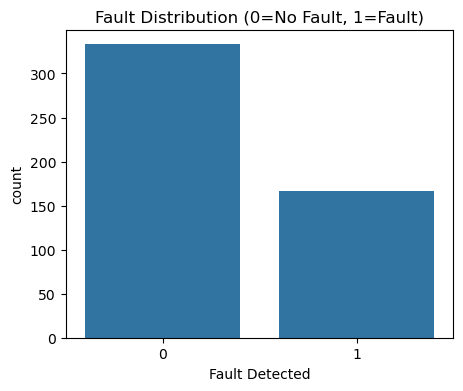

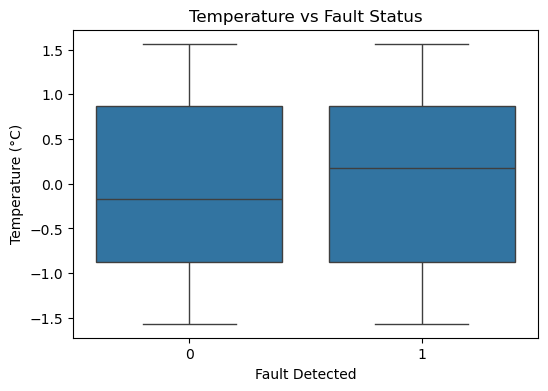

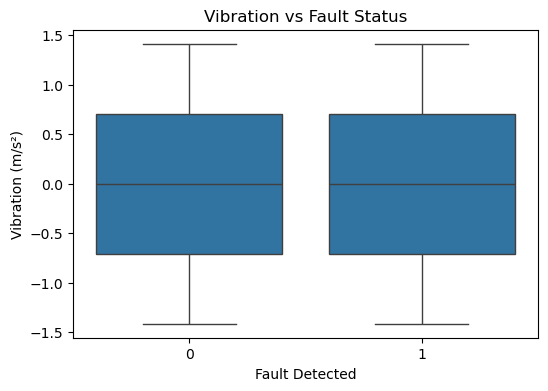

In [17]:
# Step 3: Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of target variable
plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.title("Fault Distribution (0=No Fault, 1=Fault)")
plt.show()

# Correlation heatmap of numeric features
# plt.figure(figsize=(12,8))
# sns.heatmap(data.corr(), cmap="coolwarm", center=0)
# plt.title("Correlation Heatmap")
# plt.show()

# Example: Temperature vs Fault
plt.figure(figsize=(6,4))
sns.boxplot(x=y, y=data['Temperature (°C)'])
plt.title("Temperature vs Fault Status")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=y, y=data['Vibration (m/s²)'])
plt.title("Vibration vs Fault Status")
plt.show()

In [26]:
fe_data = data.copy()

# Ensure correct ordering
fe_data = fe_data.sort_values(["Equipment_ID", "Timestamp"])

# Sensor columns available in your dataset
sensor_cols = [
    'Temperature (°C)',
    'Vibration (m/s²)',
    'Power (W)',
    'Voltage (V)',
    'Current (A)',
    'Humidity (%)'
]

# Rolling window sizes (as required by PDF)
windows = [1, 6, 12]

# ---- Rolling statistics, EMA, and Lag features ----
for col in sensor_cols:
    if col in fe_data.columns:
        for w in windows:
            # Rolling Mean
            fe_data[f"{col}_roll_mean_{w}"] = (
                fe_data.groupby("Equipment_ID")[col]
                .rolling(window=w, min_periods=1)
                .mean()
                .reset_index(level=0, drop=True)
            )

            # Rolling Standard Deviation
            fe_data[f"{col}_roll_std_{w}"] = (
                fe_data.groupby("Equipment_ID")[col]
                .rolling(window=w, min_periods=1)
                .std()
                .reset_index(level=0, drop=True)
                .fillna(0)
            )

            # Exponential Moving Average (EMA)
            fe_data[f"{col}_ema_{w}"] = (
                fe_data.groupby("Equipment_ID")[col]
                .ewm(span=w, adjust=False)
                .mean()
                .reset_index(level=0, drop=True)
            )

        # Lag Features (t-1, t-2)
        fe_data[f"{col}_lag_1"] = fe_data.groupby("Equipment_ID")[col].shift(1)
        fe_data[f"{col}_lag_2"] = fe_data.groupby("Equipment_ID")[col].shift(2)

# ---- Time since last maintenance (bonus but useful) ----
fe_data["time_since_maintenance_hours"] = (
    fe_data["Timestamp"] - fe_data["Last Maintenance Date"]
).dt.total_seconds() / 3600

# ---- Drop rows created due to lagging ----
fe_data = fe_data.dropna()

# ---- Drop identifiers AFTER feature engineering ----
drop_cols = ["Sensor_ID", "Timestamp", "Last Maintenance Date"]
fe_data = fe_data.drop(columns=[c for c in drop_cols if c in fe_data.columns])

print("Feature Engineering Complete")
print("Final Shape:", fe_data.shape)
print(fe_data.head())
fe_data.to_csv("feature_engineered_data.csv", index=False)
print("Feature-engineered dataset saved as feature_engineered_data.csv")


Feature Engineering Complete
Final Shape: (400, 95)
     Voltage (V)  Current (A)  Temperature (°C)  Power (W)  Humidity (%)  \
100    -1.566699    -1.414214         -1.566699  -1.467353     -1.566699   
150    -1.566699    -1.414214         -1.566699  -1.467353     -1.566699   
200    -1.566699    -1.414214         -1.566699  -1.467353     -1.566699   
250    -1.566699    -1.414214         -1.566699  -1.467353     -1.566699   
300    -1.566699    -1.414214         -1.566699  -1.467353     -1.566699   

     Vibration (m/s²) Equipment_ID Operational Status    Fault Status  \
100         -1.414214          E_1        Operational        No Fault   
150         -1.414214          E_1        Operational  Fault Detected   
200         -1.414214          E_1        Operational        No Fault   
250         -1.414214          E_1        Operational        No Fault   
300         -1.414214          E_1        Operational  Fault Detected   

    Failure Type  ... Humidity (%)_ema_1 Humidity (%

In [20]:
# Optional imbalance handling (explicit)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_num, y_clean)


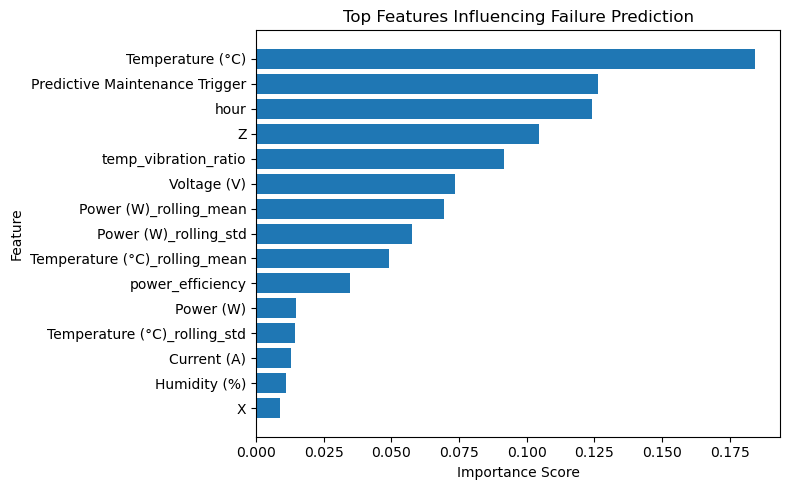

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Use trained model (rf_model or xgb_model)
importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": X_num.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(15)

plt.figure(figsize=(8,5))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top Features Influencing Failure Prediction")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Keep only numeric features
X_num = X_clean.select_dtypes(include=[np.number])

print("Numeric features used:")
print(X_num.columns.tolist())
print("Shape:", X_num.shape)

# Time-series cross validation
tscv = TimeSeriesSplit(n_splits=5)

# Baseline model (allowed by PDF)
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42
)

pr_auc_scores = []

print("\n=== TIME-SERIES CV : RANDOM FOREST BASELINE ===")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_num)):
    print(f"\n---- Fold {fold + 1} ----")

    X_train, X_test = X_num.iloc[train_idx], X_num.iloc[test_idx]
    y_train, y_test = y_clean.iloc[train_idx], y_clean.iloc[test_idx]

    rf_model.fit(X_train, y_train)

    y_probs = rf_model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= 0.5).astype(int)

    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    pr_auc_scores.append(pr_auc)

    print(f"PR-AUC: {pr_auc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

print("\nMean PR-AUC:", np.mean(pr_auc_scores))
print("STD PR-AUC:", np.std(pr_auc_scores))


Numeric features used:
['Voltage (V)', 'Current (A)', 'Temperature (°C)', 'Power (W)', 'Humidity (%)', 'Vibration (m/s²)', 'Maintenance Costs (USD)', 'Ambient Temperature (°C)', 'Ambient Humidity (%)', 'X', 'Y', 'Z', 'Predictive Maintenance Trigger', 'hour', 'day', 'month', 'dayofweek', 'Temperature (°C)_rolling_mean', 'Temperature (°C)_rolling_std', 'Vibration (m/s²)_rolling_mean', 'Vibration (m/s²)_rolling_std', 'Power (W)_rolling_mean', 'Power (W)_rolling_std', 'time_since_maintenance', 'temp_vibration_ratio', 'power_efficiency']
Shape: (500, 26)

=== TIME-SERIES CV : RANDOM FOREST BASELINE ===

---- Fold 1 ----
PR-AUC: 0.9443
Confusion Matrix:
 [[56  0]
 [13 14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90        56
           1       1.00      0.52      0.68        27

    accuracy                           0.84        83
   macro avg       0.91      0.76      0.79        83
weighted avg       0.87     

In [22]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_recall_curve, auc

# Compute class weight (preferred method)
scale_pos_weight = (y_clean == 0).sum() / (y_clean == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)


In [23]:
tscv = TimeSeriesSplit(n_splits=5)
pr_auc_scores = []

print("\n=== XGBOOST PRODUCTION MODEL (PR-AUC) ===")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_num)):
    print(f"\n--- Fold {fold + 1} ---")

    X_train, X_test = X_num.iloc[train_idx], X_num.iloc[test_idx]
    y_train, y_test = y_clean.iloc[train_idx], y_clean.iloc[test_idx]

    xgb_model.fit(X_train, y_train)

    y_probs = xgb_model.predict_proba(X_test)[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall, precision)
    pr_auc_scores.append(pr_auc)

    print(f"PR-AUC: {pr_auc:.4f}")

print("\nMean PR-AUC:", np.mean(pr_auc_scores))



=== XGBOOST PRODUCTION MODEL (PR-AUC) ===

--- Fold 1 ---
PR-AUC: 1.0000

--- Fold 2 ---
PR-AUC: 1.0000

--- Fold 3 ---
PR-AUC: 1.0000

--- Fold 4 ---
PR-AUC: 1.0000

--- Fold 5 ---
PR-AUC: 1.0000

Mean PR-AUC: 0.9999999999999998


In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [200, 300]
}

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="average_precision",  # PR-AUC
    cv=3,
    verbose=1
)

grid.fit(X_num, y_clean)

print("Best Parameters:", grid.best_params_)
print("Best PR-AUC:", grid.best_score_)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Best PR-AUC: 1.0000000000000002


In [ ]:
import joblib

joblib.dump(grid.best_estimator_, "xgboost_predictive_maintenance.joblib")
joblib.dump(X_num.columns.tolist(), "feature_list.joblib")

print("Model and features saved using joblib")
